# **MISA-MIRA LAB**
### by Sirada Kittipaisarnkul and Paola Vasquez <br>
This is the second part of the lab (MISA) the elastix, transformix and probabilistic atlas of training have been save from the code from the first oart of the lab (MIRA)

In [ ]:
!pip install itk-elastix

In [ ]:
!pip install SimpleITK

In [ ]:
!pip install SimpleITK-SimpleElastix

In [8]:
import itk
import nibabel as nib
import matplotlib.pyplot  as plt
import os
import numpy as np
from glob import glob
from tqdm import tqdm
from pathlib import Path
import numpy as np
from sklearn.cluster import KMeans
from typing import Union
from sklearn.mixture import GaussianMixture
import seaborn as sns
import time
import operator
from sklearn.metrics import jaccard_score
from scipy.ndimage import median_filter
import warnings
from functools import partial
# import SimpleITK as sitk
from itertools import permutations
from scipy.ndimage import zoom
from scipy.stats import multivariate_normal

In [9]:
training_img_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/image/training-images"
training_label_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/image/training-labels"
training_mask_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/image/training-mask"

test_img_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/test-set/testing-images"
test_label_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/test-set/testing-labels"
test_mask_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/test-set/testing-mask"
test_output_path  = "/content/drive/MyDrive/MIRA/ATLAS_LAB/test-set/testing-output"

output_dir_img = "/content/drive/MyDrive/MIRA/ATLAS_LAB/test-set/registered_image"
output_dir_label = "/content/drive/MyDrive/MIRA/ATLAS_LAB/test-set/transformed_label"


param_affine_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/Par0010affine.txt"
param_bspline_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/Par0010bspline.txt"
registered_img_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/results/register_image"
transformix_label_path = "/content/drive/MyDrive/MIRA/ATLAS_LAB/results/labels"
atlas_output_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/results/AtlasResults'

MNI_template_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/template.nii.gz'
MNI_atlas_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/atlas.nii.gz'
output_mni_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas'


training_volumes = sorted(glob(os.path.join(training_img_path,'**','*.nii.gz'), recursive = True))
training_labels = sorted(glob(os.path.join(training_label_path,'**','*.nii.gz'), recursive = True))
training_masks = sorted(glob(os.path.join(training_mask_path,'**','*.nii.gz'), recursive = True))

test_volumes = sorted(glob(os.path.join(test_img_path,'**','*.nii.gz'), recursive = True))
test_labels = sorted(glob(os.path.join(test_label_path,'**','*.nii.gz'), recursive = True))
test_masks = sorted(glob(os.path.join(test_mask_path,'**','*.nii.gz'), recursive = True))

fixed_id = 1000
fixed_image_path = os.path.join(training_img_path, f'{fixed_id}.nii.gz')        #4066 float32
fixed_image = itk.imread(fixed_image_path, itk.F)

fixed_label_path = os.path.join(training_label_path, f'{fixed_id}_3C.nii.gz')
fixed_label = itk.imread(fixed_label_path, itk.F)


## Generate Tissue Model

Ground Truth Tissue Model

100%|██████████| 15/15 [00:54<00:00,  3.60s/it]


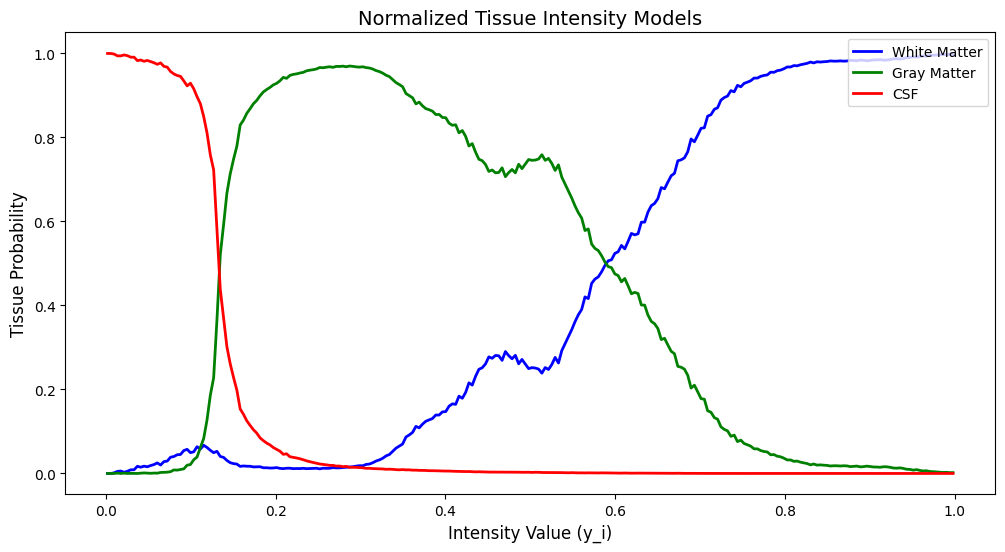

In [98]:

tissue_classes = {'WM': 2, 'GM': 3, 'CSF': 1}
tissue_intensity_counts = {tissue: np.zeros(4096) for tissue in tissue_classes.values()}

wm_intensities = []
gm_intensities = []
csf_intensities = []

# Iterate over each training image and label
for volume_path, label_path in tqdm(zip(training_volumes, training_labels), total=len(training_volumes)):
    basename_1 = os.path.basename(volume_path).split('.')[0]
    basename_2 = os.path.basename(label_path).split('.')[0].split('_')[0]

    if basename_1 == basename_2:
        # Read image and label files
        moving_image = itk.imread(volume_path, itk.F)
        moving_image_array = itk.GetArrayFromImage(moving_image)

        # Normalize the image to a standard range (0 to 4095) and convert to uint16
        normalized_image = ((moving_image_array - moving_image_array.min()) /
                            (moving_image_array.max() - moving_image_array.min()) * 4095).astype('uint16')

        label_image = itk.imread(label_path, itk.F)
        label_array = itk.GetArrayFromImage(label_image)

        # Create brain mask for skull-stripping
        brain_mask = label_array != 0  # Only keep regions where label is non-zero

        # Apply mask to intensities and labels
        brain_intensities = normalized_image[brain_mask]
        brain_labels = label_array[brain_mask]

        # Normalize intensity based on brain tissue
        max_val = np.max(brain_intensities[brain_labels == tissue_classes['WM']])
        min_val = np.min(brain_intensities[brain_labels == tissue_classes['CSF']])
        scaled_image_data = (moving_image_array - min_val) / (max_val - min_val)

        # Append scaled intensities based on tissue labels (with brain-only mask applied)
        wm_intensities.extend(scaled_image_data[label_array == tissue_classes['WM']].flatten())
        gm_intensities.extend(scaled_image_data[label_array == tissue_classes['GM']].flatten())
        csf_intensities.extend(scaled_image_data[label_array == tissue_classes['CSF']].flatten())

bins = 256  # Adjust as needed for better resolution

# Generate normalized histograms for each tissue class
wm_hist, bin_edges = np.histogram(wm_intensities, bins=bins, range=(0,1))
gm_hist, _ = np.histogram(gm_intensities, bins=bins, range=(0,1))
csf_hist, _ = np.histogram(csf_intensities, bins=bins, range=(0,1))

# Stack histograms and normalize across each bin to ensure sum equals 1
total_hist = wm_hist + gm_hist + csf_hist
wm_prob = wm_hist / total_hist
gm_prob = gm_hist / total_hist
csf_prob = csf_hist / total_hist

# Remove any NaNs from division by zero
wm_prob = np.nan_to_num(wm_prob)
gm_prob = np.nan_to_num(gm_prob)
csf_prob = np.nan_to_num(csf_prob)

# prob_mapping = np.argmax(np.vstack([csf_prob, wm_prob, gm_prob]), axis = 0) + 1

# Plotting
plt.figure(figsize=(12, 6))

# Use the midpoints of bins for plotting
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Plot each tissue class probability
plt.plot(bin_centers, wm_prob, label='White Matter', color='blue', linewidth=2)
plt.plot(bin_centers, gm_prob, label='Gray Matter', color='green', linewidth=2)
plt.plot(bin_centers, csf_prob, label='CSF', color='red', linewidth=2)

# Formatting the plot
plt.xlabel("Intensity Value (y_i)", fontsize=12)
plt.ylabel("Tissue Probability", fontsize=12)
plt.title("Normalized Tissue Intensity Models", fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(False)

# Show the plot
plt.show()

In [ ]:
gt_tissue_model = {'WM': wm_prob, 'GM': gm_prob, 'CSF': csf_prob}
# Convert NumPy arrays to lists
tissue_path =os.path.join(atlas_output_path, 'gt_tissue_model.npz')
np.savez(tissue_path, WM=wm_prob, GM=gm_prob, CSF=csf_prob)

In [ ]:
data = np.load(tissue_path)
wm_prob = data["WM"]
gm_prob = data["GM"]
csf_prob = data["CSF"]
gt_tissue_model = {'WM': wm_prob, 'GM': gm_prob, 'CSF': csf_prob}

In [100]:
gt_tissue_model = {'WM': wm_prob, 'GM': gm_prob, 'CSF': csf_prob}

Intensity atlas

# EM Algorithm

In [10]:
def segment_image_based_on_position(probabilistic_atlas):
    # Initialize an empty segmented image with the same shape as the atlas
    atlas_shape = list(probabilistic_atlas.values())[0].shape
    segmented_image = np.zeros(atlas_shape, dtype=int)
    tissue_labels = {'CSF': 1, 'GM': 3, 'WM': 2, 'Background': 0}
    for i in range(atlas_shape[0]):
        for j in range(atlas_shape[1]):
            for k in range(atlas_shape[2]):
                # Get probabilities for each tissue at this voxel
                voxel_probabilities = {tissue: probabilistic_atlas[tissue][i, j, k]
                                       for tissue in probabilistic_atlas.keys()}
                best_tissue = max(voxel_probabilities, key=voxel_probabilities.get)
                segmented_image[i, j, k] = tissue_labels[best_tissue]
    return segmented_image

In [11]:
def reconstruct_image(assignment, mask, best_permutation, img_shape):
    # Create an empty image with the original shape
    reconstructed_image = np.zeros(img_shape, dtype=int)

    # Relabel assignment values based on the best_permutation
    for i in range(len(best_permutation)):
        assignment[assignment == i] = best_permutation[i] + 1

    # Fill in the reconstructed image using the re-labeled assignments
    reconstructed_image[mask > 0] = assignment

    return reconstructed_image

In [16]:
# Dice calculation function with label argument
def dice(truth, prediction, label=1):
    truth_label = (truth == label)
    prediction_label = (prediction == label)
    intersection = np.sum(truth_label * prediction_label)
    union = np.sum(truth_label) + np.sum(prediction_label)
    dice_score = (2.0 * intersection) / (union + 1e-8)
    return dice_score

def compute_best_dice(assignment, ground_truth, mask, n_components=3):
    masked_ground_truth = ground_truth[mask > 0].flatten()
    assignment = assignment.flatten()

    if assignment.shape != masked_ground_truth.shape:
        raise ValueError(f"Shapes do not match after masking: {assignment.shape} vs {masked_ground_truth.shape}")

    best_dice_scores, best_combined_score, best_permutation = {}, 0, None

    for perm in permutations(range(n_components)):
        relabeled_assignment = np.zeros_like(assignment)
        for i in range(n_components):
            relabeled_assignment[assignment == i] = perm[i] + 1

        dice_scores = {
            tissue_class: dice(masked_ground_truth, relabeled_assignment, label=tissue_class)
            for tissue_class in range(1, n_components + 1)
        }
        combined_score = sum(dice_scores.values())

        if combined_score > best_combined_score:
            best_combined_score, best_dice_scores, best_permutation = combined_score, dice_scores, perm

    return best_dice_scores, best_permutation

def label_propagation_initialization(mask, p_atlas_csf, p_atlas_gm, p_atlas_wm, feature_data):
    # Resize probability maps to match mask shape
    zoom_factor = (mask.shape[0] / p_atlas_csf.shape[0],
                   mask.shape[1] / p_atlas_csf.shape[1],
                   mask.shape[2] / p_atlas_csf.shape[2])

    p_atlas_csf = zoom(p_atlas_csf, zoom_factor, order=1)
    p_atlas_gm = zoom(p_atlas_gm, zoom_factor, order=1)
    p_atlas_wm = zoom(p_atlas_wm, zoom_factor, order=1)

    # Extract probabilities for each tissue type based on the mask
    tissue_probs = np.zeros((len(feature_data), 3))
    tissue_probs[:, 0] = p_atlas_csf[mask > 0].flatten()  # CSF probabilities
    tissue_probs[:, 1] = p_atlas_gm[mask > 0].flatten()   # GM probabilities
    tissue_probs[:, 2] = p_atlas_wm[mask > 0].flatten()   # WM probabilities

    # Assign initial labels based on maximum probability
    assignment = np.argmax(tissue_probs, axis=1)
    return assignment


#EM Function------------------------------------------------------------------------------------------------------------

def em_segmentation(feature_data, ground_truth, mask, img_shape, init_method='kmeans',
                    tissue_models=None, influence = False, p_atlas_wm=None, p_atlas_gm=None, p_atlas_csf=None,
                    max_iter=10, tol=1e-4):
    feature_data = feature_data.reshape(-1, 1)

    # KMEANS CASE---------------------------------------------------------------------------------------------------------
    if init_method == 'kmeans':
        kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(feature_data)
        assignment = kmeans.predict(feature_data)
        centroids = kmeans.cluster_centers_.flatten()
        sorted_indices = np.argsort(centroids)

    # TISSUE MODEL CASE--------------------------------------------------------------------------------------------------
    elif init_method == 'tissue_models':
        if tissue_models is None:
            raise ValueError("Tissue models must be provided for 'tissue_model' initialization.")

        tissue_probs = np.zeros((len(feature_data), 3))
        for i, tissue in enumerate(['CSF', 'WM', 'GM']):
            tissue_probs[:, i] = tissue_models[tissue][feature_data.astype(int)].flatten()

        assignment = np.argmax(tissue_probs, axis=1)
        sorted_indices = np.array([0, 1, 2])

    # LABEL PROPAGATION CASE--------------------------------------------------------------------------------------------
    elif init_method == 'label_propagation':
        if p_atlas_wm is None or p_atlas_gm is None or p_atlas_csf is None:
            raise ValueError("p_atlas_wm, p_atlas_gm, and p_atlas_csf must be provided for 'label_propagation' initialization.")

        assignment = label_propagation_initialization(mask, p_atlas_csf, p_atlas_gm, p_atlas_wm, feature_data)
        sorted_indices = np.array([0, 1, 2])

    # Extract and initialize parameters based on sorted indices
    csf_class, gm_class, wm_class = [feature_data[assignment == idx].flatten() for idx in sorted_indices]
    csf_mean, gm_mean, wm_mean = np.mean(csf_class), np.mean(gm_class), np.mean(wm_class)
    csf_cov, gm_cov, wm_cov = np.var(csf_class) + 1e-6, np.var(gm_class) + 1e-6, np.var(wm_class) + 1e-6
    prior_csf, prior_gm, prior_wm = len(csf_class) / len(feature_data), len(gm_class) / len(feature_data), len(wm_class) / len(feature_data)
    cls_dist = np.array([prior_csf, prior_gm, prior_wm])
    n_step, log_likelihood_prev = 0, None

    def gmm(x, mean, cov):
        return multivariate_normal.pdf(x, mean=mean, cov=cov)

    atlas_probs = np.vstack((p_atlas_csf[mask > 0].flatten(),
                             p_atlas_gm[mask > 0].flatten(),
                             p_atlas_wm[mask > 0].flatten())).T

    # EM Algorithm Steps
    while n_step < max_iter:
        gmm_csf, gmm_gm, gmm_wm = gmm(feature_data, csf_mean, csf_cov), gmm(feature_data, gm_mean, gm_cov), gmm(feature_data, wm_mean, wm_cov)
        denominator = (prior_csf * gmm_csf) + (prior_gm * gmm_gm) + (prior_wm * gmm_wm)
        weight_csf, weight_gm, weight_wm = (prior_csf * gmm_csf) / denominator, (prior_gm * gmm_gm) / denominator, (prior_wm * gmm_wm) / denominator

        weights = np.vstack((weight_csf, weight_gm, weight_wm)).T

        #INTO EM--------------------------------------------
        if influence:
            weights *= atlas_probs  # Incorporate atlas information
            weights /= weights.sum(axis=1, keepdims=True)  # Normalize to ensure they sum to 1


        log_likelihood = np.sum(np.log(denominator))

        if log_likelihood_prev is not None and abs(log_likelihood - log_likelihood_prev) < tol:
            break
        log_likelihood_prev = log_likelihood

        prior_csf, prior_gm, prior_wm = np.mean(weight_csf), np.mean(weight_gm), np.mean(weight_wm)
        csf_mean = np.sum(weight_csf * feature_data.flatten()) / np.sum(weight_csf)
        gm_mean = np.sum(weight_gm * feature_data.flatten()) / np.sum(weight_gm)
        wm_mean = np.sum(weight_wm * feature_data.flatten()) / np.sum(weight_wm)

        csf_cov = np.sum(weight_csf * (feature_data.flatten() - csf_mean) ** 2) / np.sum(weight_csf) + 1e-6
        gm_cov = np.sum(weight_gm * (feature_data.flatten() - gm_mean) ** 2) / np.sum(weight_gm) + 1e-6
        wm_cov = np.sum(weight_wm * (feature_data.flatten() - wm_mean) ** 2) / np.sum(weight_wm) + 1e-6
        cls_dist = np.array([prior_csf, prior_gm, prior_wm])
        n_step += 1

    #A Posteriori----------------------------------------------
    adjusted_weights = weights * atlas_probs
    assignment = np.argmax(adjusted_weights, axis=-1)

    best_dice_scores, best_permutation = compute_best_dice(assignment, ground_truth, mask)
    segmented_image = reconstruct_image(assignment, mask, best_permutation, img_shape)

    return segmented_image, best_dice_scores, best_permutation

In [14]:
def plot_combined_segmentation(segmented_image, ground_truth, best_dice_scores, best_permutation, slice_index=None):
    if slice_index is None:
        slice_index = segmented_image.shape[2] // 2  # Default to the middle slice

    # Define the explicit intensity values for CSF=1, WM=2, GM=3
    intensity_mapping = {best_permutation[0]: 1, best_permutation[1]: 2, best_permutation[2]: 3}
    combined_segmented_image = np.zeros_like(segmented_image)

    # Map each tissue class in segmented image using intensity_mapping
    for i, class_label in enumerate(best_permutation):
        combined_segmented_image[segmented_image == (i + 1)] = intensity_mapping[class_label]

    # Plot segmented image vs ground truth
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle("Comparison of Segmented Image and Ground Truth")

    # Display segmented image
    axes[0].imshow(combined_segmented_image[:, :, slice_index], cmap="gray")
    axes[0].set_title(f"Segmented Image\nDice Scores: CSF={best_dice_scores[1]:.4f}, "
                      f"GM={best_dice_scores[2]:.4f}, WM={best_dice_scores[3]:.4f}")
    axes[0].axis("off")

    # Display ground truth
    axes[1].imshow(ground_truth[:, :, slice_index], cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()



Processing volume 1003.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1003/1003_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1003/1003_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1003/1003_p_atlas_wm.nii.gz


invalid value encountered in divide


Best Dice Scores: {1: 0.09865495320982602, 2: 0.8639192367783891, 3: 0.8973783142131774}
Best Label Permutation: (0, 2, 1)


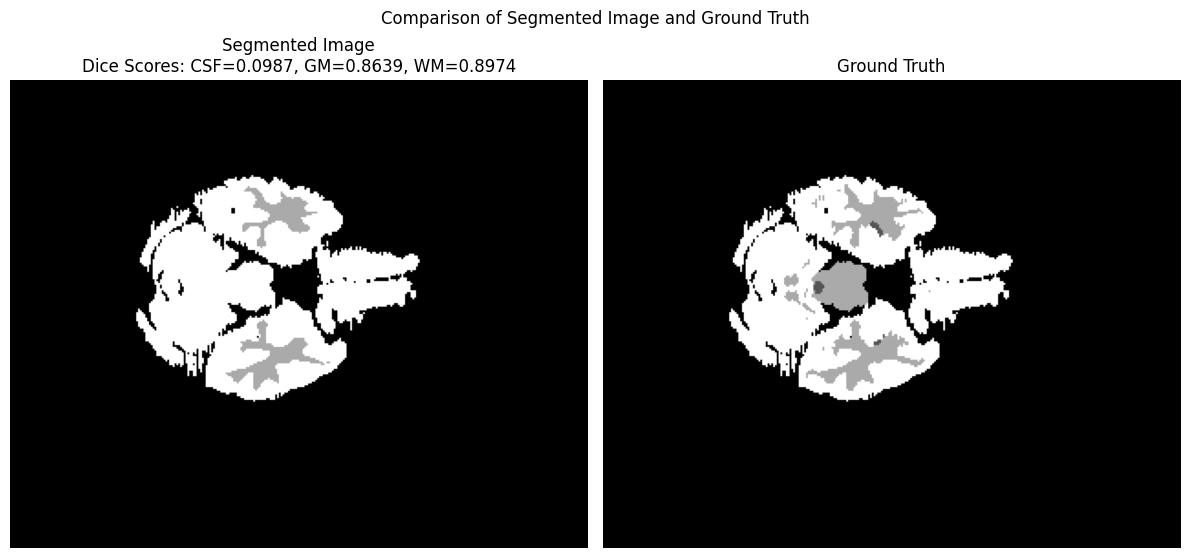

Processing volume 1004.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1004/1004_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1004/1004_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1004/1004_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.12460349501124032, 2: 0.8395347858470364, 3: 0.8758819910323505}
Best Label Permutation: (0, 2, 1)


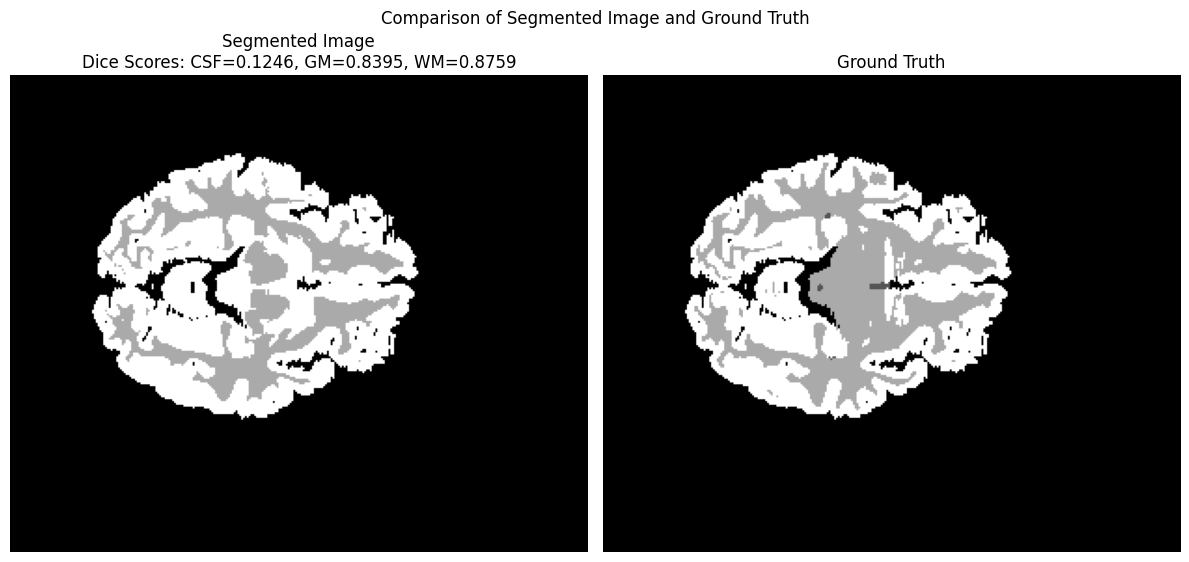

Processing volume 1005.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1005/1005_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1005/1005_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1005/1005_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.22055104150035623, 2: 0.6977766052291545, 3: 0.8031827976786702}
Best Label Permutation: (0, 2, 1)


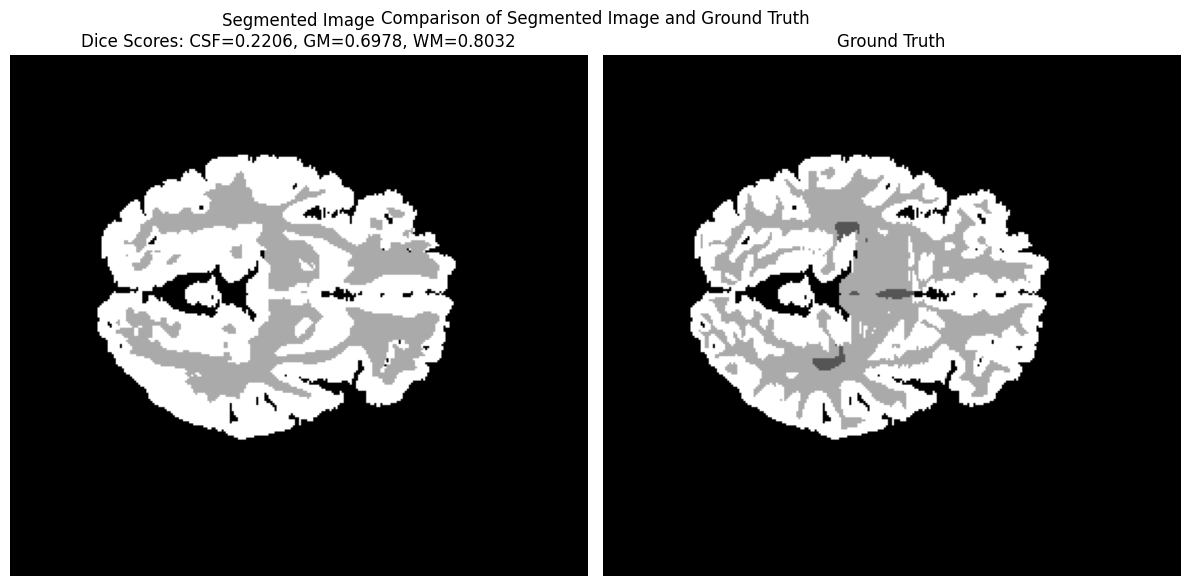

Processing volume 1018.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.14687030579853952, 2: 0.8574637114825638, 3: 0.8961424726716882}
Best Label Permutation: (0, 2, 1)


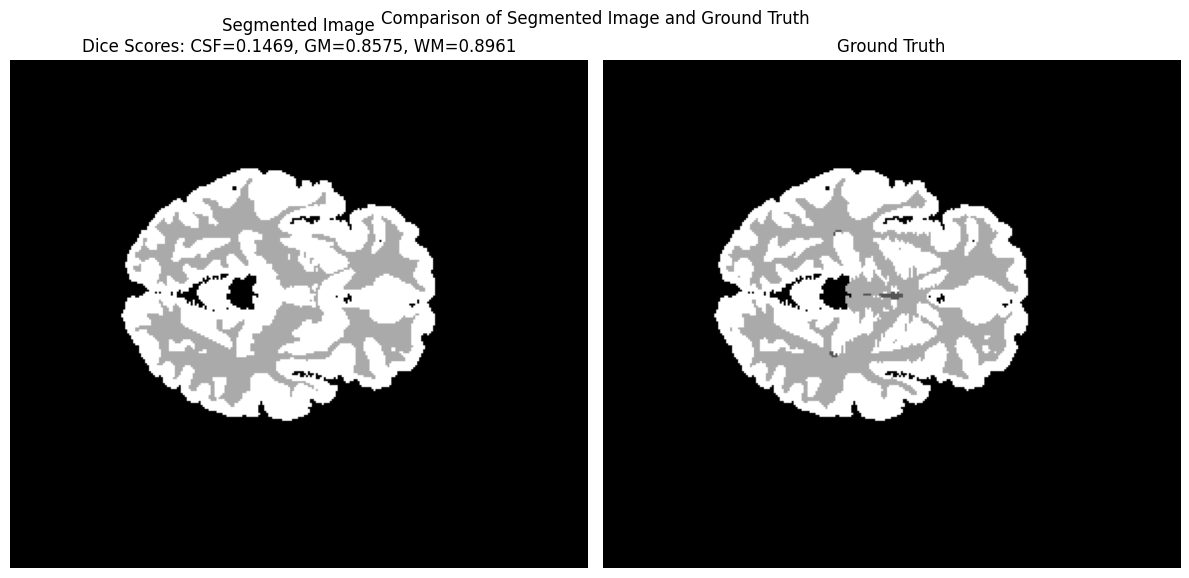

Processing volume 1019.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1019/1019_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1019/1019_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1019/1019_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.07446923365150263, 2: 0.8283027296990696, 3: 0.8749415254720686}
Best Label Permutation: (0, 2, 1)


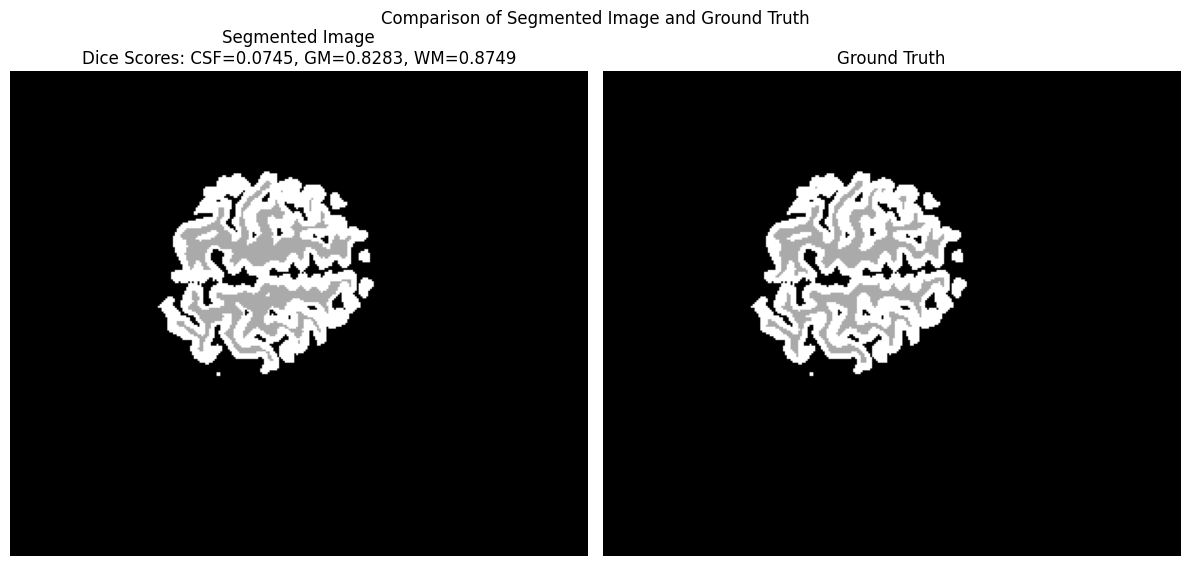

Processing volume 1023.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1023/1023_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1023/1023_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1023/1023_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.10014392022317183, 2: 0.8614551819396737, 3: 0.892914118674365}
Best Label Permutation: (0, 2, 1)


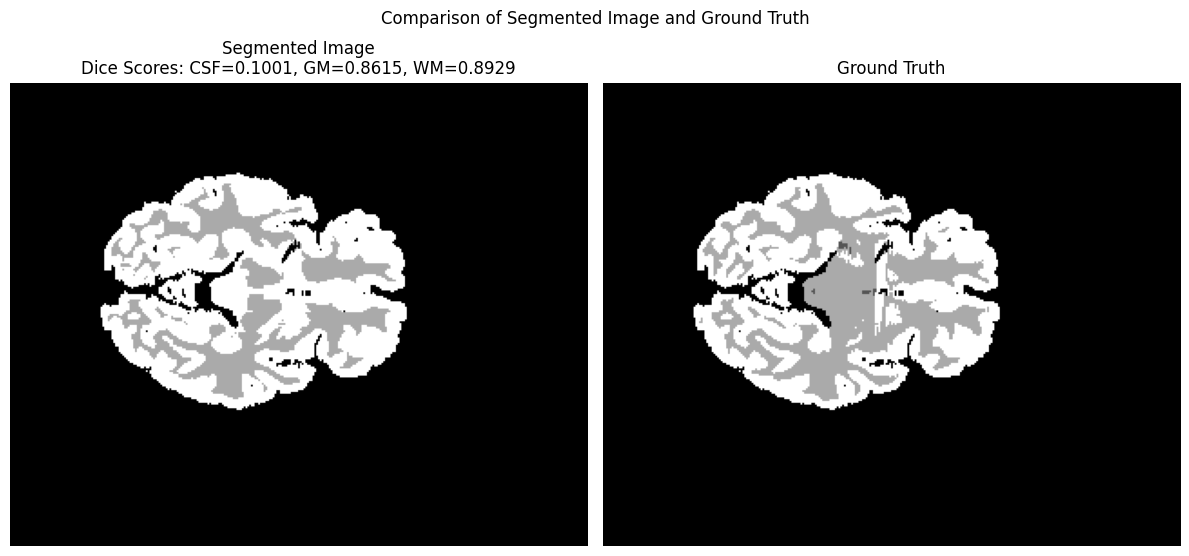

Processing volume 1024.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1024/1024_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1024/1024_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1024/1024_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.1144466521706477, 2: 0.848500644599486, 3: 0.8846478076270127}
Best Label Permutation: (0, 2, 1)


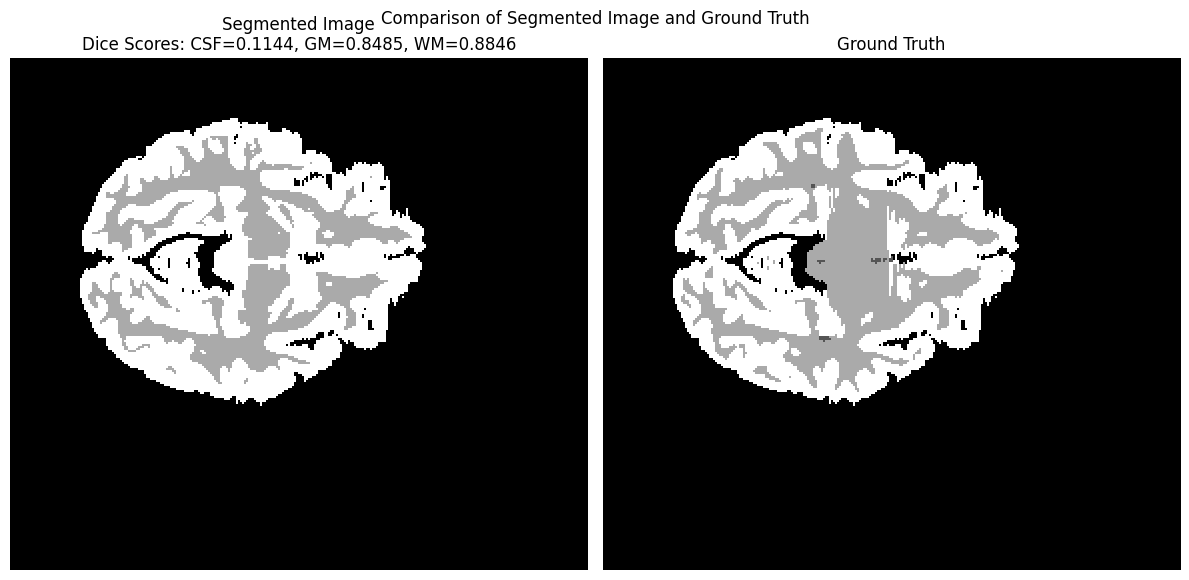

Processing volume 1025.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1025/1025_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1025/1025_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1025/1025_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.2075490158543708, 2: 0.7084841911688754, 3: 0.814508927664819}
Best Label Permutation: (0, 2, 1)


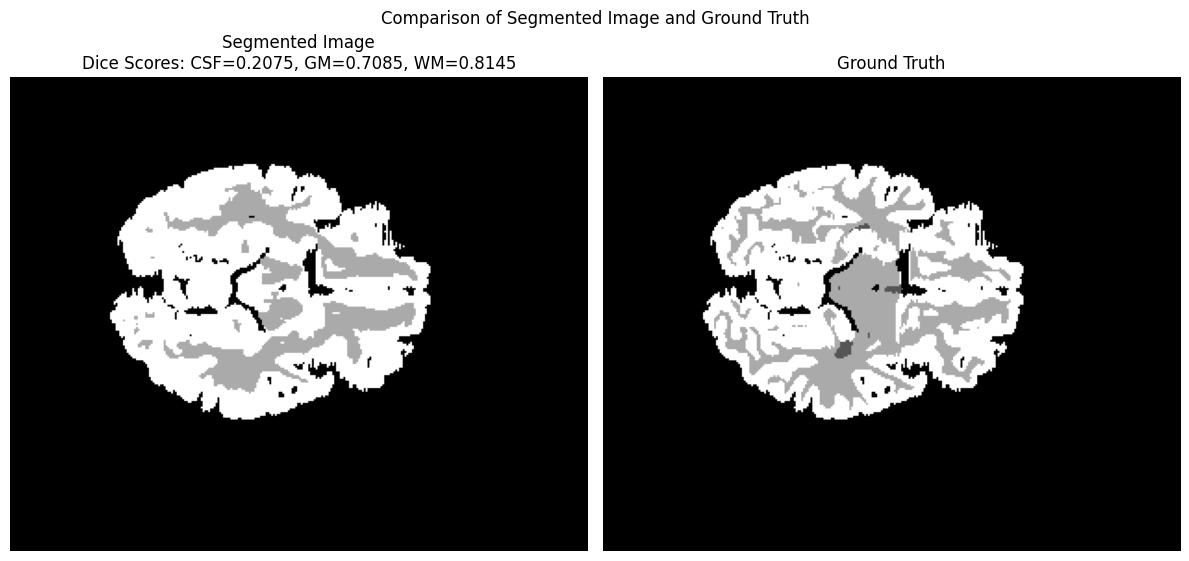

Processing volume 1038.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1038/1038_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1038/1038_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1038/1038_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.16829408784603217, 2: 0.8605035132976043, 3: 0.8978681361977837}
Best Label Permutation: (0, 2, 1)


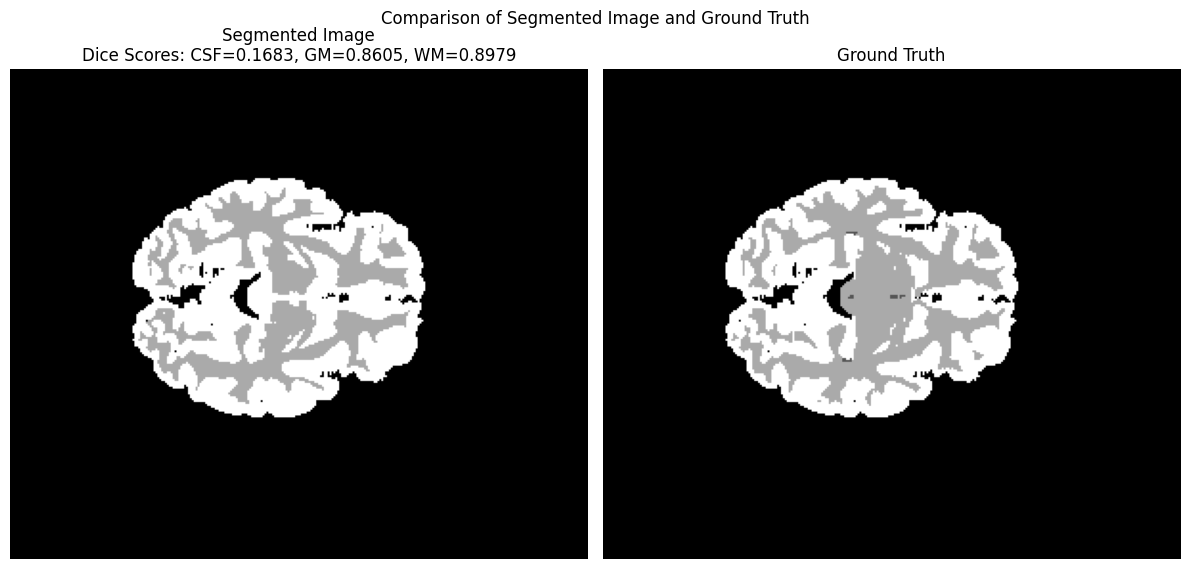

Processing volume 1039.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1039/1039_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1039/1039_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1039/1039_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.0825898348980199, 2: 0.8438397963759423, 3: 0.8837958856994463}
Best Label Permutation: (0, 2, 1)


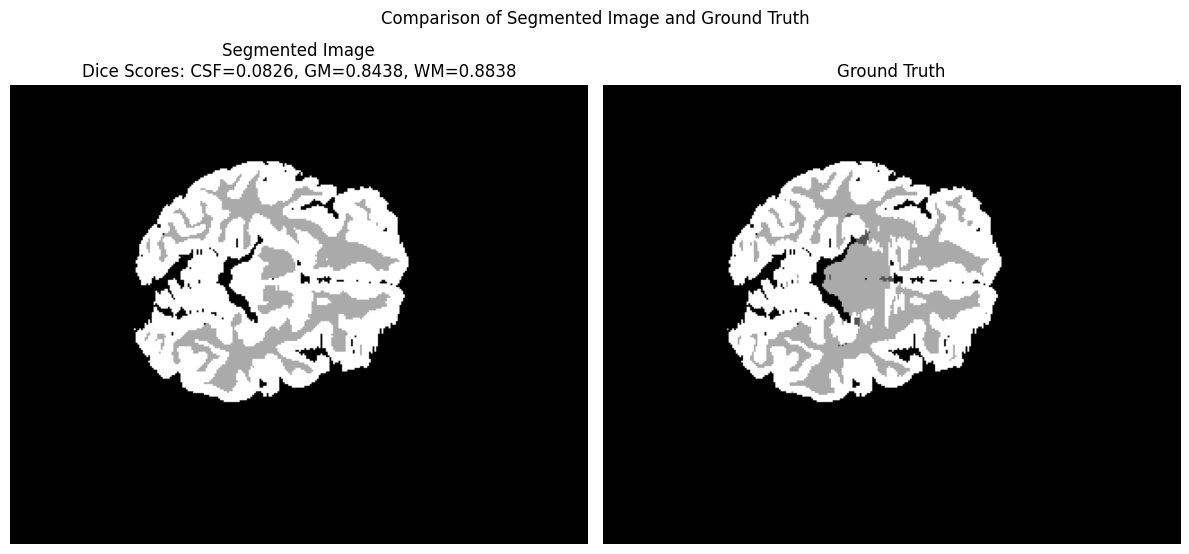

Processing volume 1101.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1101/1101_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1101/1101_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1101/1101_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.1566483373550105, 2: 0.8234548630546321, 3: 0.8582039981747664}
Best Label Permutation: (0, 2, 1)


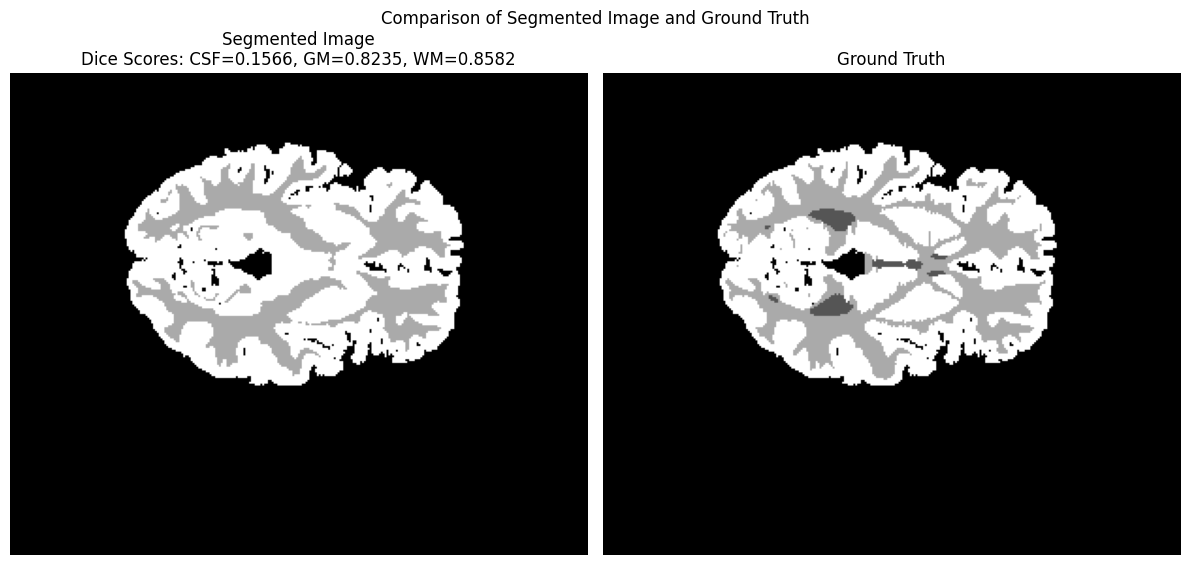

Processing volume 1104.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1104/1104_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1104/1104_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1104/1104_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.1399784541604748, 2: 0.8287121576978207, 3: 0.8727446300715939}
Best Label Permutation: (0, 2, 1)


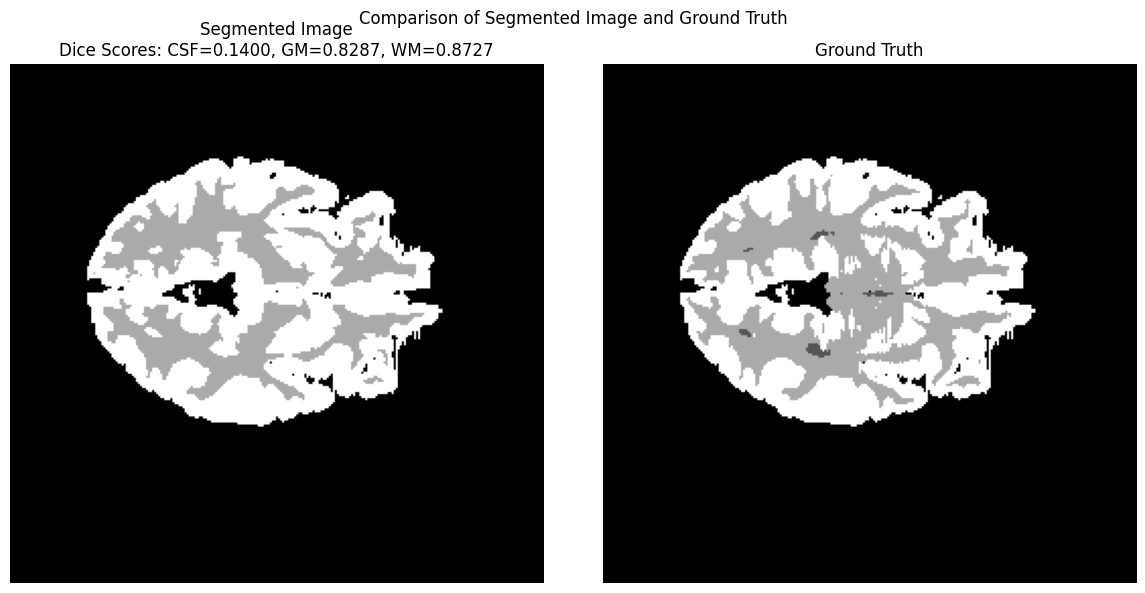

Processing volume 1107.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1107/1107_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1107/1107_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1107/1107_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.14442167456218766, 2: 0.8456535922678762, 3: 0.8720766583214435}
Best Label Permutation: (0, 2, 1)


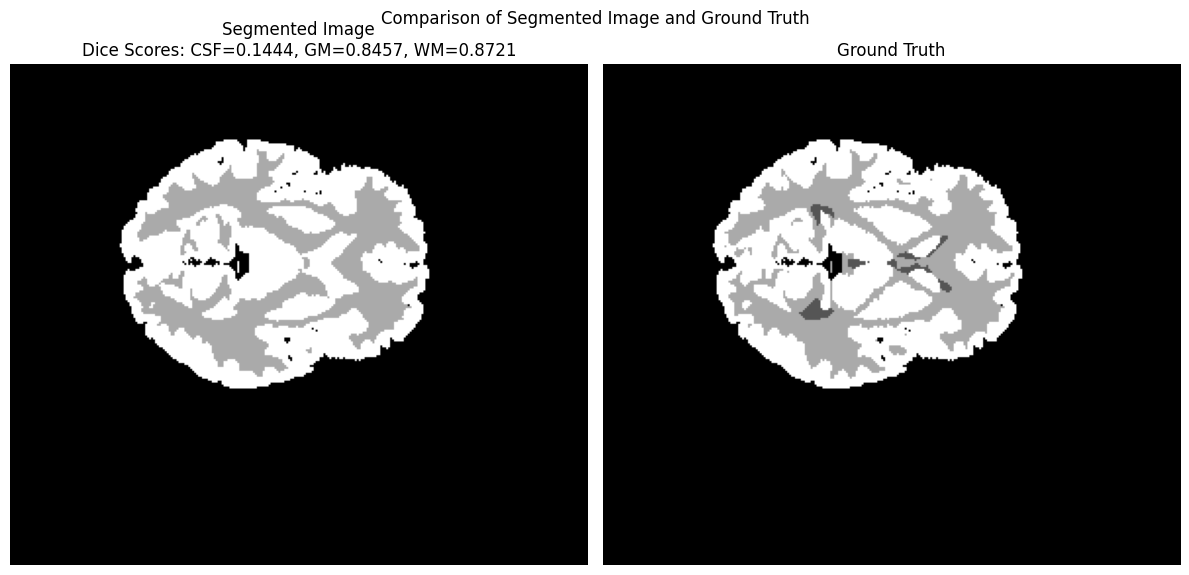

Processing volume 1110.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1110/1110_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1110/1110_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1110/1110_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.1702610936865481, 2: 0.8510548346897087, 3: 0.876678069811016}
Best Label Permutation: (0, 2, 1)


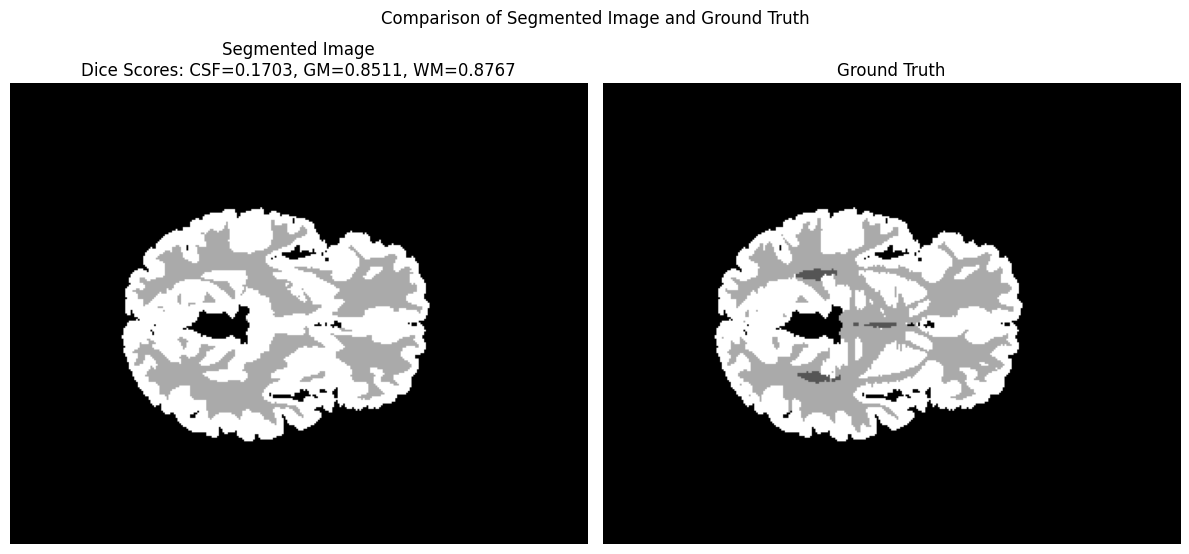

Processing volume 1113.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1113/1113_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1113/1113_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1113/1113_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.15478846840413274, 2: 0.8488881249208292, 3: 0.8684842457282661}
Best Label Permutation: (0, 2, 1)


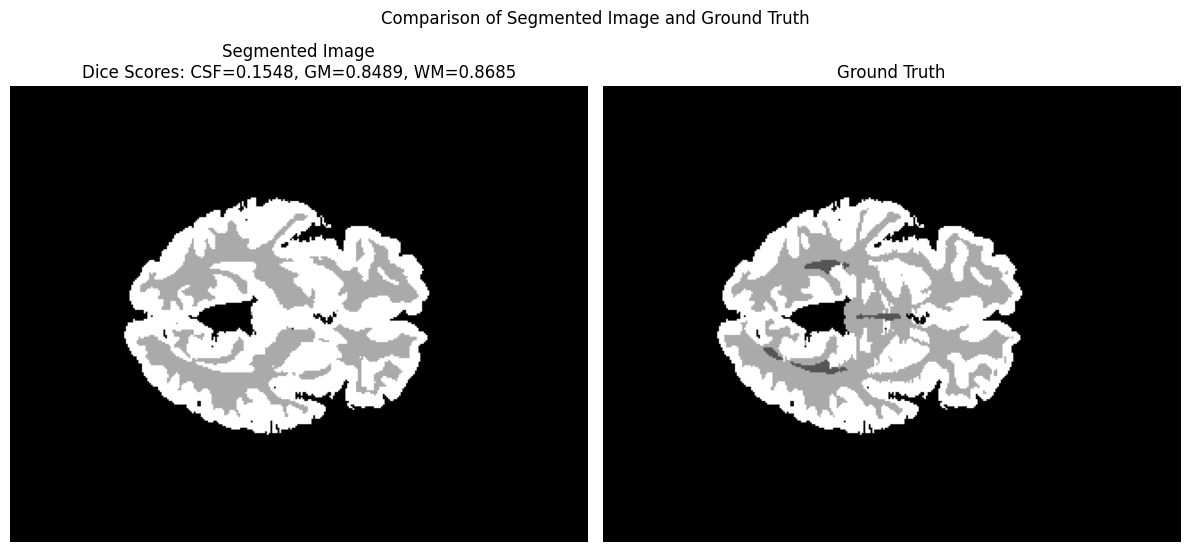

Processing volume 1116.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1116/1116_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1116/1116_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1116/1116_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.2434345965879485, 2: 0.8048925663080005, 3: 0.852133633642744}
Best Label Permutation: (0, 2, 1)


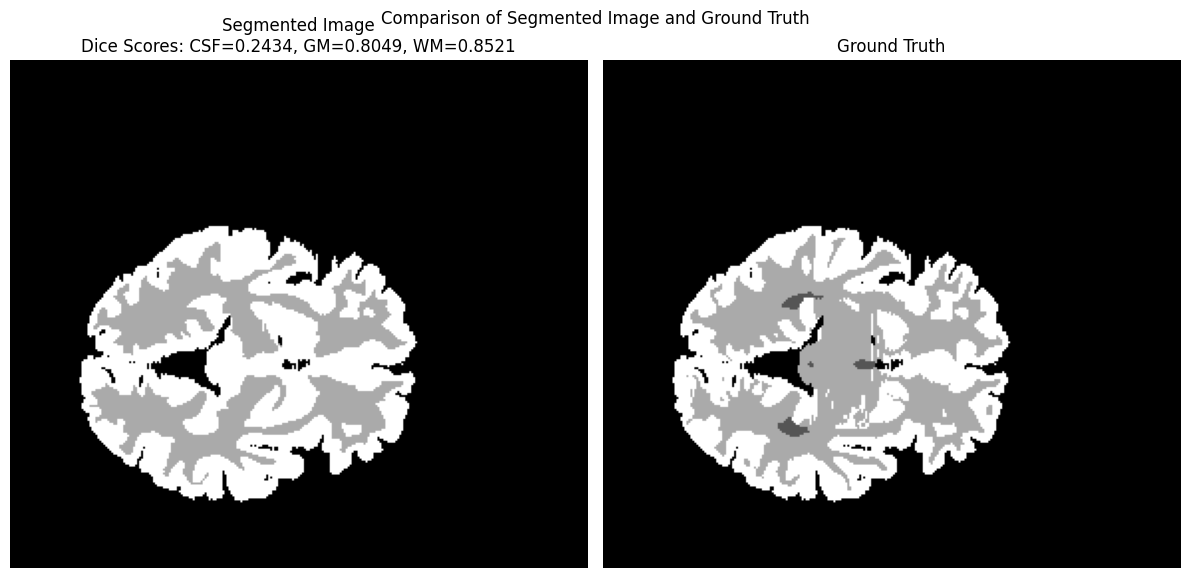

Processing volume 1119.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1119/1119_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1119/1119_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1119/1119_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.18989544546524192, 2: 0.6862907717713138, 3: 0.7754711501674746}
Best Label Permutation: (0, 2, 1)


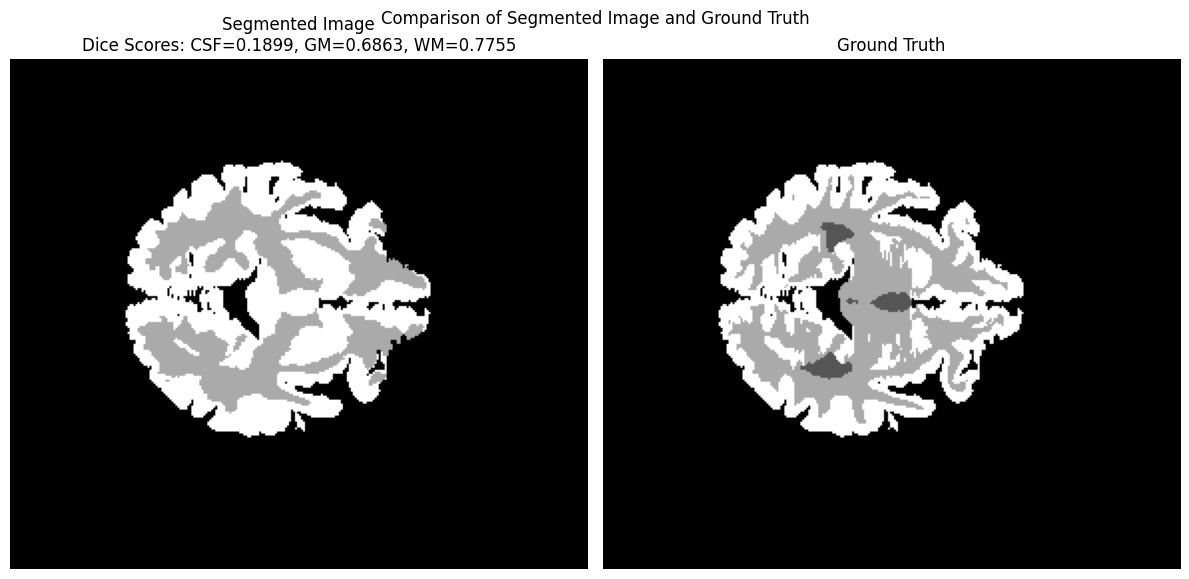

Processing volume 1122.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1122/1122_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1122/1122_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1122/1122_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.303032513800716, 2: 0.7455317884961777, 3: 0.8151994698782754}
Best Label Permutation: (0, 2, 1)


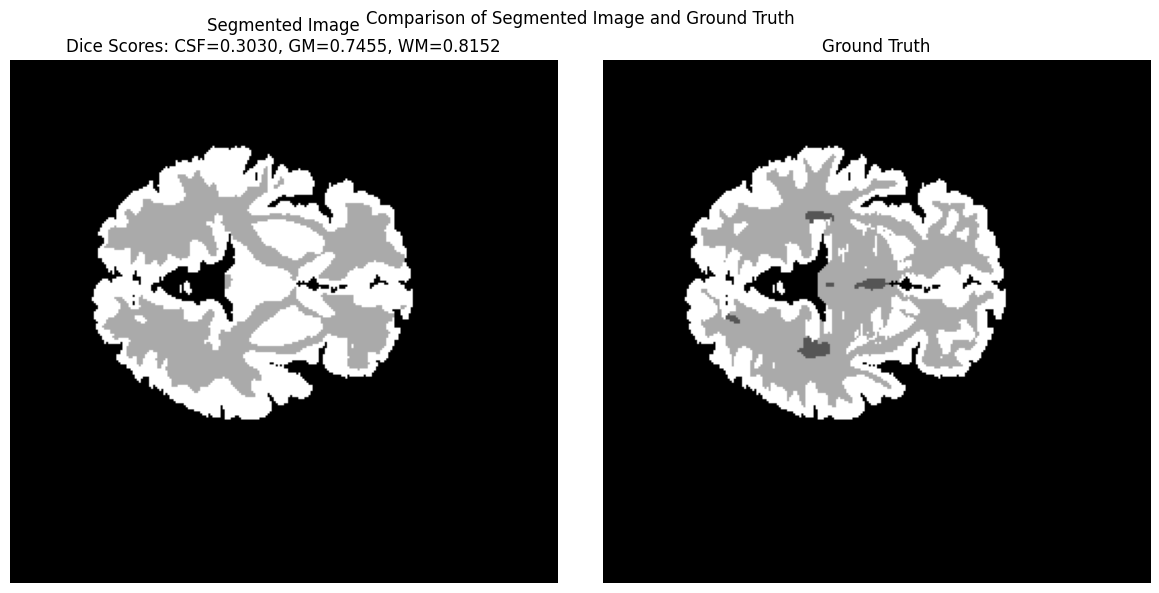

Processing volume 1125.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1125/1125_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1125/1125_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1125/1125_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.25440965482318106, 2: 0.6451996562589442, 3: 0.7844771913344634}
Best Label Permutation: (0, 2, 1)


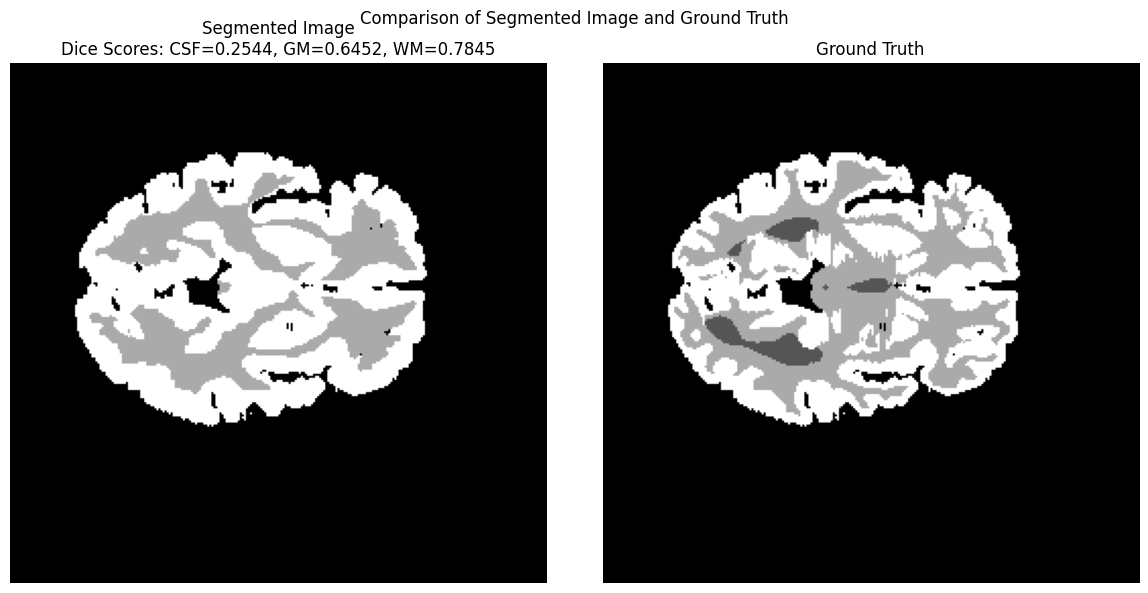

Processing volume 1128.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1128/1128_p_atlas_csf.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1128/1128_p_atlas_gm.nii.gz
/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1128/1128_p_atlas_wm.nii.gz
Best Dice Scores: {1: 0.23876690768088193, 2: 0.6923927026468477, 3: 0.739023050566262}
Best Label Permutation: (0, 2, 1)


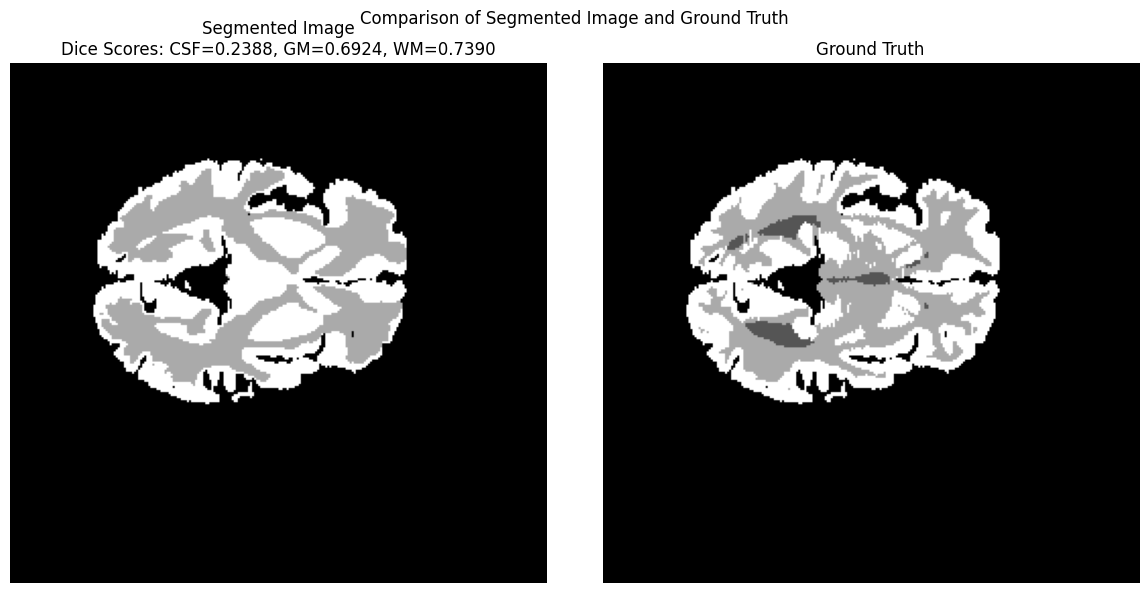

In [17]:
p_atlas_wm_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/results/AtlasResults/p_atlas_wm.nii.gz'
p_atlas_gm_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/results/AtlasResults/p_atlas_gm.nii.gz'
p_atlas_csf_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/results/AtlasResults/p_atlas_csf.nii.gz'

mni_atlas_dir = '/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas'

p_atlas_wm = nib.load(p_atlas_wm_path).get_fdata()
p_atlas_gm = nib.load(p_atlas_gm_path).get_fdata()
p_atlas_csf = nib.load(p_atlas_csf_path).get_fdata()

# Function to perform segmentation on a batch of images
def batch_segmentation(test_volumes, test_labels, test_masks, slice_index=125):
    results = []

    for elem in os.listdir(test_img_path):
        print(f"Processing volume {elem}")

        # Load the current image, mask, and label
        img = elem
        label = elem.split('.')[0]+'_3C.nii.gz'
        mask = elem.split('.')[0]+'_1C.nii.gz'

        test_image_name = img.split('.')[0]

        current_path = os.path.join(mni_atlas_dir, test_image_name)

        tissue_types = ['csf', 'gm', 'wm']

        atlas=[]
        # Loop through the tissue types
        for tissue_type in tissue_types:
            # Construct the path to the probabilistic atlas file
            p_atlas_path = os.path.join(mni_atlas_dir, f'{test_image_name}/{test_image_name}_p_atlas_{tissue_type}.nii.gz')
            nii = nib.load(p_atlas_path)
            atlas.append(nii.get_fdata())
            print(p_atlas_path)
        atlas = np.stack(atlas, axis=-1)

        img_data = nib.load(os.path.join(test_img_path, elem))
        img_data_affine = img_data.affine
        img_data_header = img_data.header
        img_data = img_data.get_fdata()

        label_data = nib.load(os.path.join(test_label_path, label))
        ground_truth_data = label_data.get_fdata() if not isinstance(label_data, np.ndarray) else label_data

        mask_data = nib.load(os.path.join(test_mask_path, mask))
        mask_data = mask_data.get_fdata()
        mask_data = (mask_data > 0).astype(int)

        # Apply mask to get only the brain region
        masked_intensity_data = img_data * mask_data
        brain_flatten = masked_intensity_data.copy().flatten()

        # Filter out non-zero feature data
        feature_data = brain_flatten[brain_flatten > 0]

        # Perform EM segmentation
        segmented_image, best_dice_scores, best_permutation = em_segmentation(
            feature_data=feature_data,
            ground_truth=ground_truth_data,
            mask=mask_data,
            img_shape=img_data.shape,
            init_method='label_propagation',
            tissue_models=None,
            p_atlas_wm=atlas[:,:,:,2],
            p_atlas_gm=atlas[:,:,:,1],
            p_atlas_csf=atlas[:,:,:,0],
            influence=True,
        )

        print("Best Dice Scores:", best_dice_scores)
        print("Best Label Permutation:", best_permutation)

        # Store the result
        results.append({
            'segmented_image': segmented_image,
            'best_dice_scores': best_dice_scores,
            'best_permutation': best_permutation
        })

        # Plot the result for the specified slice index
        plot_combined_segmentation(segmented_image, ground_truth_data, best_dice_scores, best_permutation, slice_index=slice_index)

    return results

# Run the batch segmentation
results = batch_segmentation(test_volumes, test_labels, test_masks, slice_index=125)

## Register MNI to Test Img

In [7]:
def save_segementations(
    volume: np.ndarray, reference: sitk.Image, filepath: Path
):
    if (type(volume) == list) or (len(volume.shape) > 3):
        if type(volume[0]) == sitk.Image:
            vol_list = [vol for vol in volume]
        else:
            vol_list = [sitk.GetImageFromArray(vol) for vol in volume]
        joiner = sitk.JoinSeriesImageFilter()
        img = joiner.Execute(*vol_list)
    else:
        img = sitk.GetImageFromArray(volume)
    img.SetDirection(reference.GetDirection())
    img.SetOrigin(reference.GetOrigin())
    img.SetSpacing(reference.GetSpacing())
    for key in reference.GetMetaDataKeys():
        img.SetMetaData(key, reference.GetMetaData(key))
    sitk.WriteImage(img, filepath)

In [9]:


mni_atlas_template     = sitk.ReadImage(MNI_template_path)
mni_atlas_labels       = sitk.ReadImage(MNI_atlas_path)
mni_atlas_labels_array = sitk.GetArrayFromImage(mni_atlas_labels)

mni_atlas_background = mni_atlas_labels_array[0, :, :, :]
mni_atlas_csf        = mni_atlas_labels_array[1, :, :, :]
mni_atlas_gm         = mni_atlas_labels_array[2, :, :, :]
mni_atlas_wm         = mni_atlas_labels_array[3, :, :, :]

# save_segementations(mni_atlas_background, mni_atlas_template , os.path.join(output_mni_path, 'p_atlas_background.nii.gz'))
# save_segementations(mni_atlas_csf, mni_atlas_template , os.path.join(output_mni_path,'p_atlas_csf.nii.gz'))
# save_segementations(mni_atlas_gm, mni_atlas_template , os.path.join(output_mni_path,'p_atlas_gm.nii.gz'))
# save_segementations(mni_atlas_wm, mni_atlas_template , os.path.join(output_mni_path,'p_atlas_wm.nii.gz'))

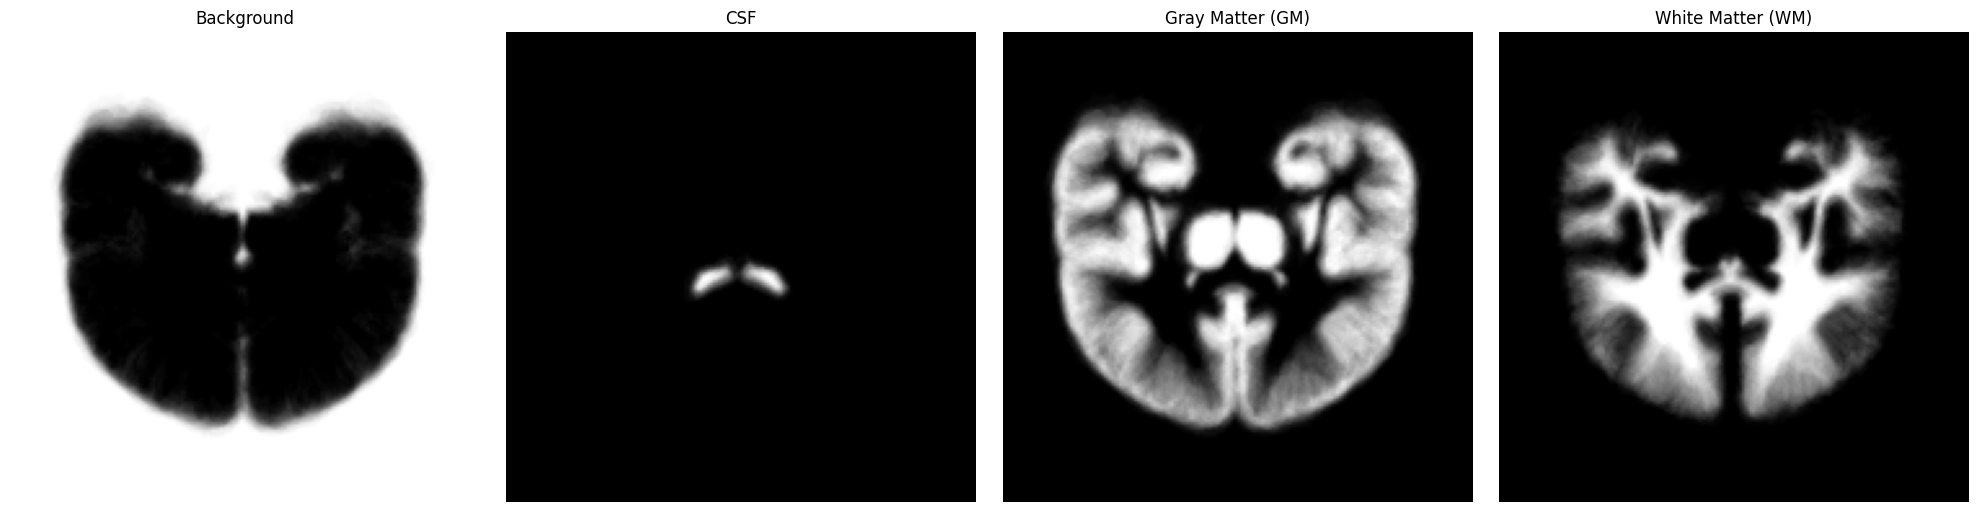

In [11]:
def display_mni_atlas_slices(mni_atlas_background, mni_atlas_csf, mni_atlas_gm, mni_atlas_wm, slice_axis=1):
    # Select the middle slice index for the specified axis
    slice_idx_bg = mni_atlas_background.shape[slice_axis] // 2
    slice_idx_csf = mni_atlas_csf.shape[slice_axis] // 2
    slice_idx_gm = mni_atlas_gm.shape[slice_axis] // 2
    slice_idx_wm = mni_atlas_wm.shape[slice_axis] // 2

    # Get the slice along the specified axis
    slice_bg = mni_atlas_background.take(slice_idx_bg, axis=slice_axis)
    slice_csf = mni_atlas_csf.take(slice_idx_csf, axis=slice_axis)
    slice_gm = mni_atlas_gm.take(slice_idx_gm, axis=slice_axis)
    slice_wm = mni_atlas_wm.take(slice_idx_wm, axis=slice_axis)

    # Plot slices side by side
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(slice_bg, cmap='gray')
    axes[0].set_title('Background')
    axes[1].imshow(slice_csf, cmap='gray')
    axes[1].set_title('CSF')
    axes[2].imshow(slice_gm, cmap='gray')
    axes[2].set_title('Gray Matter (GM)')
    axes[3].imshow(slice_wm, cmap='gray')
    axes[3].set_title('White Matter (WM)')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
display_mni_atlas_slices(mni_atlas_background, mni_atlas_csf, mni_atlas_gm, mni_atlas_wm, slice_axis=1)

In [61]:
# Register test image using mni atlas
output_mni_regis_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/results'
param_MNI_path = '/content/drive/MyDrive/MIRA/ATLAS_LAB/Par0009.affine.txt'

parameter_object = itk.ParameterObject.New()
parameter_object.AddParameterFile(param_MNI_path)
parameter_object.SetParameter("ResampleInterpolator", "FinalNearestNeighborInterpolator")

moving_image = itk.imread(MNI_template_path, itk.F)

atlas_path           = {'mni_atlas': output_mni_path}
atlas_template_path  = {'mni_atlas': MNI_template_path}
atlas_mapping_names  = ['p_atlas_background', 'p_atlas_csf', 'p_atlas_gm', 'p_atlas_wm']

for fixed_image_path, mask_path in (zip(test_volumes,test_masks)):
  # fixed_image_name = fixed_image_path.name.rstrip('.nii.gz')
  fixed_image_name = os.path.basename(fixed_image_path).replace(".nii.gz", "")
  mask_image = itk.imread(mask_path, itk.F)
  fixed_image = itk.imread(fixed_image_path, itk.F)


  for atlas_name in ['mni_atlas']:
        # result_path = os.path.join(output_mni_regis_path, f'registered_{fixed_image_name}_{atlas_name}.nii.gz')
    result_path = test_outputs_dir_path / atlas_name / fixed_image_name
    result_path.mkdir(exist_ok=True, parents=True)
    reg_test_volume = os.path.join(result_path, f'{atlas_name}_template.nii.gz')
    reg_mask_volume = os.path.join(result_path, f'{fixed_image_name}_1C.nii.gz')
    transform_param_path = os.path.join(result_path, f'TransformParameter.txt')

    reg_img , reg_transform_param = itk.elastix_registration_method(fixed_image, moving_image,parameter_object=parameter_object, log_to_console=False )
    # itk.imwrite(reg_img, reg_test_volume)


    # #Transform Brain mask
    # transform_mask = itk.transformix_filter(mask_image,reg_transform_param )
    # itk.imwrite(transform_mask, reg_mask_volume)

     # Transform and save each probabilistic atlas map (CSF, GM, WM)
    for label_name in atlas_mapping_names:
      label_path = Path(atlas_path[atlas_name]) / f'{label_name}.nii.gz'
      label_image = itk.imread(str(label_path), itk.F)
      transformed_label = itk.transformix_filter(label_image, reg_transform_param)

      # Save the transformed probabilistic atlas map for the tissue type
      res_label_path = os.path.join(result_path, f'{fixed_image_name}_{label_name}.nii.gz')
      itk.imwrite(transformed_label, res_label_path)



Displaying Mask


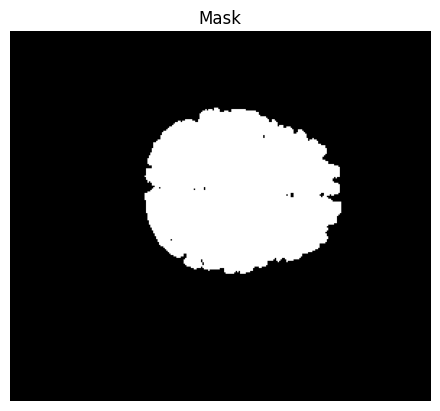

Displaying Background


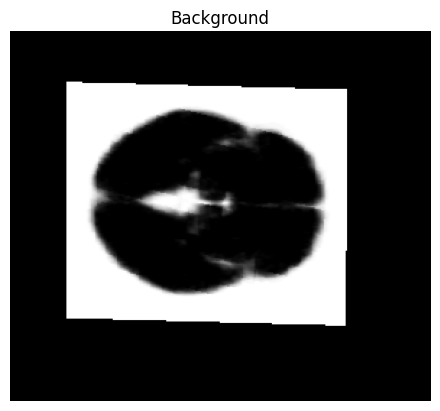

Displaying CSF


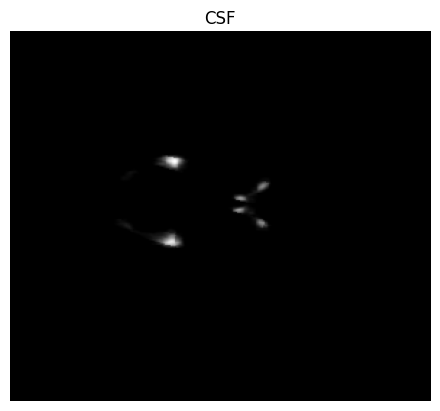

Displaying GM


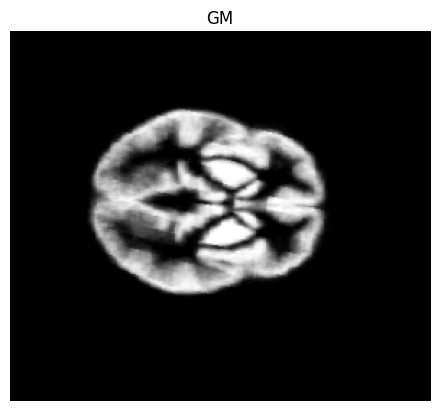

Displaying WM


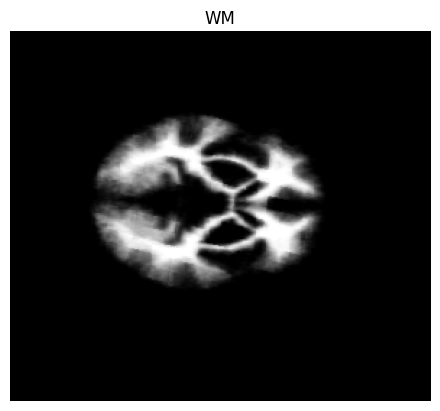

Displaying Template


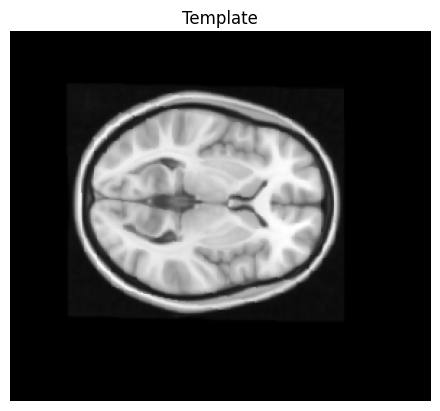

In [64]:
files = {
    "Mask": "/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_1C.nii.gz",
    "Background": "/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_p_atlas_background.nii.gz",
    "CSF": "/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_p_atlas_csf.nii.gz",
    "GM": "/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_p_atlas_gm.nii.gz",
    "WM": "/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/1018_p_atlas_wm.nii.gz",
    "Template": "/content/drive/MyDrive/MIRA/ATLAS_LAB/MNITemplateAtlas/test_results/mni_atlas/1018/mni_atlas_1018_template.nii.gz"
}

# Function to display a middle slice of the 3D image
def show_middle_slice(filepath, title="Image"):
    img = nib.load(filepath)
    data = img.get_fdata()
    middle_slice = data.shape[2] // 2  # Choose the middle slice along the third dimension

    plt.imshow(data[:, :, middle_slice], cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Loop through each image and display
for label, filepath in files.items():
    print(f"Displaying {label}")
    show_middle_slice(filepath, title=label)